# CalEnviroScreen and ML Environmental Justice Communities in the Inland Empire

In 2016, the California legislature passed and Governor Brown signed SB 1000, requiring local governments with environmental justice communities, defined as “disadvantaged communities” in statute, to identify said communities in their jurisdiction and include a separate Environmental Justice (EJ) element, or related goals, policies, and objectives integrated in other elements, in their general plan upon the adoption or next revision of two or more elements concurrently. SB 1000 grants jurisdiction discretion over their disadvantaged community screening analysis. In statute, “disadvantaged communities” means either census tracts that have a combined CalEnviroScreen score of 75% or higher, or an area that is a low-income area, in reference to the statewide median income or the Department of Housing and Community Development’s list of state income limits, that is disproportionately affected by environmental pollution and other hazards that can lead to negative health effects, exposure, or environmental degradation.

The City of Fontana has adopted an Environmental Justice Appendix to their general plan to address SB 1000 which inadequately identifies disadvantaged communities, according to the Attorney General’s Office. 

Research Question: How does a machine learning classification scheme to identify Environmental Justice (EJ) communities compare to the indexing approach used by CalEnviroScreen 4.0 in the Inland Empire? How do the characteristics of the EJ communities identified by machine learning but not CalEnviroScreen 4.0 or vice versa differ? 
Data Sources (informed by Oakland’s SB 1000 methodology): 
- CalEnviroScreen 4.0
- US Dept. of Housing and Urban Development (HUD) Comprehensive Housing Affordability Strategy (CHAS) 2015-2019 
- 2019 ACS Data
- California Natural Resources Agency (CNRA) California Heat Assessment and Vulnerability Tool 
- US Department of Agriculture Food Access Research Atlas 2019


# Data Wrangling: Getting and Cleaning Data, Creating Variables, and Preparing for Joins

## CalEnviroScreen4.0

Load data from CalEnviroScreen4.0

In [1]:
# Import os to change directory
import os
# Import pandas 
import pandas as pd
# Import geopandas
import geopandas as gpd
# Import numpy
import numpy as np
# Get mapping to crop raster with shapefile
from shapely.geometry import mapping
# Importing excel reader
import openpyxl

In [2]:
# Change directory to location of CalEnviroScreen data
os.chdir('Data/CalEnviroScreen')

In [3]:
# Load in CalEnviroScreen Data
esGdf = gpd.read_file('CES4 Final Shapefile.shp')

In [4]:
# Restrict census tracts to Riverside and San Bernardino Counties
esGdf_InlandEmpire = esGdf[esGdf['County'].isin(['Riverside', 'San Bernardino'])]

In [5]:
# Define disadvantaged communities as those with CalEnviroScreen score percentile ≥ 75
esGdf_InlandEmpire['CalEnviroScreen_EJ'] = esGdf_InlandEmpire['CIscoreP'].apply(lambda x: True if x >= 75 else False) 

/Users/samanthasmithies/anaconda3/envs/uds/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
# Use only raw scores as x-variables
# List comprehension to exclude percentile columns and scores
cols_to_exclude = [col for col in esGdf_InlandEmpire.columns if col.endswith('P') or col.endswith('score') or col.endswith('Sc')
                   or col=='PollBurd' or col=='PopChar']
esGdf_InlandEmpire_rawscores = [col for col in esGdf_InlandEmpire.columns if col not in cols_to_exclude]

# Subset dataframe to only include raw scores
esGdf_InlandEmpire= esGdf_InlandEmpire[esGdf_InlandEmpire_rawscores]

# Edit tract number to match the GEOID in other datasets; add leading zero
esGdf_InlandEmpire['GEOID'] = esGdf_InlandEmpire.Tract.astype(np.int64).astype(str).str.zfill(11)

# Set GEOID as index to join with other datasets
esGdf_InlandEmpire.set_index('GEOID', inplace=True)

## American Community Survey (2019)

Use API connection to get data from 2019 American Community Survey (ACS) 

In [7]:
import cenpy
from cenpy import products
# create a connection to the American Community Survey
acs = cenpy.products.ACS()

All variables required from ACS: 
- Total Population (used to scale for percentages): B01001_001E
- Estimate!!Total:!!White alone = B02001_002E
- Male under 5= B01001_003E, Female under 5= B01001_027E, 
- Older populations: Estimate!!Total:!!Female:!!65 and older = B01001_044E, B01001_045E, B01001_046E, B01001_047E, B01001_048E, B01001_049E
- Estimate!!Total:!!Male:!!65 and older = B01001_020E, B01001_021E, B01001_022E, B01001_023E, B01001_024E, B01001_025E,
- Median Household Income = B19013_001E,  
- Estimate!!Total:!!Male:!!Not Enrolled in school: SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS = B14005_007E,
- Estimate!!Total:!!Female:!!Not enrolled in school: SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS = B14005_021E, 
- Estimate!!Total: SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS = B14005_001E, 
- Estimate!!Total:!!No Internet access = B28002_013E,
- Estimate!!Total:!!Internet access without a subscription = B28002_012E,
- Estimate!!Total: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD = B28002_001E,
- Estimate!!Total:!!Under 18 years:!!With one type of disability = C18108_003E
- Estimate!!Total:!!Under 18 years:!!With one type of disability = C18108_004E
- Estimate!!Total:!!18 to 64 years!!With one type of disability = C18108_007E
- Estimate!!Total:!!18 to 64 years:!!With two or more disabilities = C18108_008E 
- Estimate!!Total:!!65 years and over:!!With one type of disability = C18108_011E
- Estimate!!Total:!!65 years and over:!!With two or more disabilities = C18108_012E
- Estimate!!Total!! AGE BY NUMBER OF DISABILITIES= C18108_001E
- Estimate!!Total:!!No Internet access = B28002_013E
- Estimate!!Total:!!1.01 or more occupants per room = B25014H_003E
- Estimate!!Total!!Owner occupied!!No vehicle available = B25044_003E 
- Estimate!!Total!!Renter occupied!!No vehicle available = B25044_010E
- Estimate!!Total!!Owner occupied!!1 vehicle available = B25044_004E
- Estimate!!Total!!Renter occupied!!1 vehicle available = B25044_011E
- Estimate!!Total: TENURE BY VEHICLES AVAILABLE = B25044_001E
- Estimate!!Total!! means of transportation to work = B08301_001E
- Estimate!!Total!!Walked = B08301_019E
- Estimate!!Total!!Bicycle = B08301_018E
- Estimate!!Total:!!90 or more minutes time to travel to work = B08303_013E
- Estimate!!Total: TRAVEL TIME TO WORK = B08303_001E 
- Estimate!!Total:!!No fuel used = B25040_010E 
- Estimate!!Total: HOUSE HEATING FUEL = B25040_001E 
- Estimate!!Total:!!Owner occupied:!!1.01 to 1.50 occupants per room = B25014_005E, 
- Estimate!!Total:!!Owner occupied:!!1.51 to 2.00 occupants per room = B25014_006E,
- Estimate!!Total:!!Owner occupied:!!2.01 or more occupants per room = B25014_007E, 
- Estimate!!Total:!!Renter occupied:!!1.01 to 1.50 occupants per room = B25014_011E,
- Estimate!!Total:!!Renter occupied:!!1.51 to 2.00 occupants per room = B25014_012E,
- Estimate!!Total:!!Renter occupied:!!2.01 or more occupants per room = B25014_013E, 
- Estimate!!Total: TENURE BY OCCUPANTS PER ROOM = B25014_001E

In [9]:
census_var = ['B01001_001E', 'B01001_003E', 'B01001_027E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E',
              'B19013_001E', 'B14005_001E', 'B14005_007E', 'B14005_021E', 'B28002_002E', 'B25040_010E', 'B25040_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E', 'B25014_011E', 'B25014_012E', 'B25014_013E', 'B02001_001E','B02001_002E', 
              'C18108_001E', 'C18108_003E', 'C18108_004E', 'C18108_007E','C18108_008E', 'C18108_011E', 'C18108_012E', 'B28002_001E', 'B28002_012E', 'B28002_013E', 'B25014H_003E', 'B25044_001E', 'B25044_003E', 'B25044_010E', 'B25044_004E', 'B25044_011E', 
              'B08301_001E', 'B08301_019E', 'B08301_018E', 'B08303_013E', 'B08303_001E'] 

In [10]:
# Get 2019 ACS for Riverside and San Bernardino counties
censusDf_Riverside = products.ACS(2019).from_county('Riverside, CA', level='tract',
                                        variables=census_var)
censusDf_San_Bernardino = products.ACS(2019).from_county('San Bernardino, CA', level='tract',
                                        variables=census_var)

/Users/samanthasmithies/anaconda3/envs/uds/lib/python3.9/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)
/Users/samanthasmithies/anaconda3/envs/uds/lib/python3.9/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)


In [11]:
# Concatenate Riverside and San Bernardino county data
censusDf_IE = pd.concat((censusDf_Riverside, censusDf_San_Bernardino), axis=0)

In [13]:
## SOCIOECONOMIC VULNERABILITY FACTORS ##
## Age
censusDf_IE['pct_youngchild'] = ((censusDf_IE['B01001_003E'] + censusDf_IE['B01001_027E'])/censusDf_IE['B01001_001E'])*100 # male under 5 + female under 5, divided by total population
older_pop = ['B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E'] # All variables for male and female populations greater than 65
censusDf_IE['pct_older'] = (censusDf_IE[older_pop].sum(axis=1)/censusDf_IE['B01001_001E'])*100 # Sum all counts of people 65+/total population
## Disability
disability= ['C18108_003E', 'C18108_004E', 'C18108_007E','C18108_008E', 'C18108_011E', 'C18108_012E']
censusDf_IE['pct_disability'] = (censusDf_IE[disability].sum(axis=1)/censusDf_IE['C18108_001E'])*100 # sum number of estimated total of people in each range with one or more disabilities, divide by total polled population
# Median Household Income
censusDf_IE['med_income']= censusDf_IE['B19013_001E']
# Disconnected Youth (16-19 year olds not in school) 
censusDf_IE['pct_disconnectedyouth']= ((censusDf_IE['B14005_007E'] + censusDf_IE['B14005_021E'])/censusDf_IE['B14005_001E'])*100 # sum number of 16-19 males and females not enrolled in school/population of 16-19 year olds
# Internet Access (percentage of households without internet subscription)
censusDf_IE['pct_woutinternet'] = ((censusDf_IE['B28002_013E'] + censusDf_IE['B28002_012E'])/censusDf_IE['B28002_001E'])*100 # number of households without any internet or internet subscription/total number of households polled

In [14]:
## TRANSPORTATION ##   
# Vehicle ownership 
vehicles = ['B25044_003E', 'B25044_010E', 'B25044_004E', 'B25044_011E'] # all owner-occupied (0 or 1 cars) and rental (0 or 1 cars)                                     
censusDf_IE['pct_lessthan2vehicles'] = ((censusDf_IE[vehicles].sum(axis=1))/censusDf_IE['B25044_001E'])*100 # sum number of owner-occupied or rental households with 0 or 1 cars/total households polled
# Active Commute
censusDf_IE['pct_activecommute'] = ((censusDf_IE['B08301_019E'] + censusDf_IE['B08301_018E'])/censusDf_IE['B08301_001E'])*100 # sum of walking and biking commuters/total number of commuters 
# Extreme Commutes 
censusDf_IE['pct_extremecommute'] = (censusDf_IE['B08303_013E']/censusDf_IE['B08303_001E'])*100 # proportion of commuters traveling 90+ minutes

In [15]:
## HOUSING ##
# House Heating
censusDf_IE['pct_nofuel']= (censusDf_IE['B25040_010E']/censusDf_IE['B25040_001E'])*100 # number of households with no heating fuel/total households
# Overcrowding
occupants = ['B25014_005E', 'B25014_006E', 'B25014_007E', 'B25014_011E', 'B25014_012E', 'B25014_013E'] # owner and rent-occupied 1+ people per room 
censusDf_IE['pct_1+occupants']= (censusDf_IE[occupants].sum(axis=1)/censusDf_IE['B25014_001E'])*100 # sum of households with 1+ people per room/total households

In [16]:
# Drop all of the ACS variable names and keep variables we created 
censusDf_IE =censusDf_IE.drop(labels=['geometry','B01001_001E', 'B01001_003E', 'B01001_027E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E',
              'B19013_001E', 'B14005_001E', 'B14005_007E', 'B14005_021E', 'B28002_002E', 'B25040_010E', 'B25040_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E', 'B25014_011E', 'B25014_012E', 'B25014_013E', 'B02001_002E', 
              'C18108_001E', 'C18108_003E', 'C18108_004E', 'C18108_007E','C18108_008E', 'C18108_011E', 'C18108_012E', 'B28002_001E', 'B28002_012E', 'B28002_013E', 'B25014H_003E', 'B25044_001E', 'B25044_003E', 'B25044_010E', 'B25044_004E', 'B25044_011E', 
              'B08301_001E', 'B08301_019E', 'B08301_018E', 'B08303_013E', 'B08303_001E'], axis=1)

In [17]:
# Set index as GEOID to use for joining datasets 
censusDf_IE.set_index('GEOID', inplace=True)

## US Dept. of Housing and Urban Development (HUD)


Pull in the data from HUD Comprehensive Housing Affordability Strategy (CHAS) 2015-2019


In [18]:
# Change directory to location of HUD data
os.chdir('../HUD CHAS')
hamfiDf = pd.read_csv('Table16.csv')
len(hamfiDf)

# Select HUD CHAS data for census tracts in the IE
hamfiDfIE = hamfiDf[hamfiDf['name'].str.contains("Riverside")|hamfiDf['name'].str.contains("San Bernardino")].reset_index()

Calculate percentage of households per tract that make 30% or less than the HUD Area Median Family Income (HAMFI).

In [19]:
# Identify percentage of households per tract that make 30% or less than the HUD Area Median Family Income (HAMFI).
hamfiDfIE['HAMFI30'] = ((hamfiDf['T16_est3'] + hamfiDf['T16_est88'])/hamfiDf['T16_est1'])*100
#hamfiDfIE.head()

# Get GEOID for HUD Area Median Family Income data 
hamfiDfIE['GEOID'] = hamfiDfIE['geoid'].str[7:]

# Subset dataframe to only include columns of interest
hamfiDfIE= hamfiDfIE[['GEOID', 'HAMFI30']]

# Set GEOID as index for joining datasets
hamfiDfIE.set_index('GEOID', inplace=True)

# Add name to HAMFI series so it can be joined with dataframes
hamfiDfIE.name = 'HAMFI'

## California Natural Resources Agency (CNRA) 

Pull in the California Natural Resources Agency (CNRA) California
Heat Assessment Tool (CHAT) 2015 data

In [20]:
# # Change directory to location of CNRA CHAT data
os.chdir('../CHAT')
CHATRiversideDf = pd.read_csv('CHAT-Riverside County-projected.csv')
CHATSBDf = pd.read_csv('CHAT-San Bernardino County-projected.csv')

# Concatenate Riverside and San Bernardino data
CHATIE = pd.concat((CHATRiversideDf, CHATSBDf), axis=0)

Select time frame as 2021-2040 and time of year as June, July, and August for general population for the 50th percentile of models. Use the 'business as usual' emissions scenario.  

In [21]:
CHATIE_selected= CHATIE[(CHATIE['projections_time_frame'] == '2021-2040') & (CHATIE['rcp']== 'rcp85') & (CHATIE['socioeconomic_group'] == 'General') & (CHATIE['time_of_year']=='JJA') & (CHATIE['model_percentiles'] == 50)]

# Get GEOID for CHAT  
CHATIE_selected['GEOID'] = CHATIE_selected['geoid_long'].str[9:]

# Select Heat Health Events Max Temperature
CHATIE_maxtemp = CHATIE_selected[['proj_avg_tmax', 'GEOID']]

# Set GEOID as index to join with other datasets
CHATIE_maxtemp.set_index('GEOID', inplace=True)

# Add name to CHAT series so it can be joined with dataframes
CHATIE_maxtemp.name = 'Max_Temp'

/var/folders/nt/pqtkb2xn7dv92qdv8m3dc9380000gn/T/ipykernel_49343/535864412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CHATIE_selected['GEOID'] = CHATIE_selected['geoid_long'].str[9:]


Pull in the California Natural Resources Agency (CNRA) California Heat Assessment Tool (CHAT) 2015 Vulnerability data for Riverside and San Bernardino counties. This contains tree canopy coverage by census tract. 

In [22]:
# Vulnerability Indicators for Heat-related Health Events
CHATRiversideDf_tcc = pd.read_csv('CHAT-Riverside County-vulnerability-indicators(1).csv')
CHATSBDf_tcc = pd.read_csv('CHAT-San Bernardino County-vulnerability-indicators.csv')

In [23]:
# Concatenate Riverside and San Bernardino Data
CHATIE_tcc = pd.concat((CHATRiversideDf_tcc, CHATSBDf_tcc), axis=0)

In [24]:
# Edit tract number to match the GEOID in other datasets
CHATIE_tcc['census_tract'] = CHATIE_tcc.census_tract.astype(np.int64).astype(str).str.zfill(11)

# Select percent no tree canopy 
CHATIE_tcc = CHATIE_tcc[['perc_no_tree_canopy', 'census_tract']]

In [25]:
# Set Census Tract as index 
CHATIE_tcc.set_index('census_tract', inplace=True)

# Add name to series so it can be joined with dataframes
CHATIE_tcc.name = 'Tree_Canopy'

## Romitti et al. 2022: Probability of Residential Air Conditioning

 Load data for probability of residential air conditioning from Romitti et al. csv

In [26]:
# Change directory and read in data
os.chdir('../AC')
ac_data = pd.read_csv('US_metro_ac_prob-1.csv')

# Restrict Census Tracts to Riverside and San Bernardino
acdata_IE= ac_data[ac_data['NAME'].str.contains("Riverside")|ac_data['NAME'].str.contains("San Bernardino")].reset_index()

# Take the inverse of the AC probability to use as a vulnerability metric
acdata_IE['inverse_ac_prob']= 1/acdata_IE['ac_prob']

# Add leading zero to TRACT_GEOID column to match the other GEOID codes 
acdata_IE['TRACT_GEOID']= acdata_IE.TRACT_GEOID.astype(str).str.zfill(11)

# Select TRACT_GEOID and inverse of AC probability as relevant variables
acdata_IE=acdata_IE[['TRACT_GEOID', 'inverse_ac_prob']]

# Set TRACT_GEOID as index
acdata_IE.set_index('TRACT_GEOID', inplace=True)

# Add name to AC data series so it can be joined with dataframes
acdata_IE.name = 'AC_Data'

## USDA: Food Access Research Atlas 2019


Load the Data from the Food Access Research Atlas, which has already been subset to San Bernardino and Riverside counties because the original excel file was too big to push to GitHub easily. 

In [27]:
# Read in pickle that was subset to Riverside and San Bernardino Counties
snap_dataIE = pd.read_pickle('../snap_dataIE.pandas')

In [28]:
# Create variable for percent of households receiving SNAP
snap_dataIE['pct_SNAP']= (snap_dataIE['TractSNAP']/snap_dataIE['OHU2010'])*100

# Subset the dataframe to include relevant columns
snap_dataIE= snap_dataIE[['CensusTract', 'pct_SNAP']]

# Add leading zero to TRACT_GEOID column to match the other GEOID codes 
snap_dataIE['CensusTract']= snap_dataIE.CensusTract.astype(str).str.zfill(11)

# Set TRACT_GEOID as index
snap_dataIE.set_index('CensusTract', inplace=True)

# Add name to SNAP data series so it can be joined with dataframes
snap_dataIE.name = 'SNAP_usage'

# Joining Data Sources and Preparing for Modeling

In [29]:
# Create list of all dataframes/Series to join 
dfs = [esGdf_InlandEmpire, censusDf_IE, hamfiDfIE, CHATIE_maxtemp, CHATIE_tcc, acdata_IE, snap_dataIE]
# Perform join of all datasets by GEOID as index
total_variables = dfs[0].join(dfs[1:])

In [30]:
total_variables.columns

Index(['Tract', 'County', 'ApproxLoc', 'TotPop19', 'Ozone', 'PM2_5',
       'DieselPM', 'Pesticide', 'Tox_Rel', 'Traffic', 'DrinkWat', 'Lead',
       'Cleanup', 'GWThreat', 'HazWaste', 'ImpWatBod', 'SolWaste', 'Asthma',
       'LowBirtWt', 'Cardiovas', 'Educatn', 'Ling_Isol', 'Poverty', 'Unempl',
       'HousBurd', 'Child_10', 'Pop_10_64', 'Elderly65', 'Hispanic', 'White',
       'AfricanAm', 'NativeAm', 'OtherMult', 'Shape_Leng', 'Shape_Area',
       'AAPI', 'geometry', 'CalEnviroScreen_EJ', 'B02001_001E', 'state',
       'county', 'tract', 'NAME', 'pct_youngchild', 'pct_older',
       'pct_disability', 'med_income', 'pct_disconnectedyouth',
       'pct_woutinternet', 'pct_lessthan2vehicles', 'pct_activecommute',
       'pct_extremecommute', 'pct_nofuel', 'pct_1+occupants', 'HAMFI30',
       'proj_avg_tmax', 'perc_no_tree_canopy', 'inverse_ac_prob', 'pct_SNAP'],
      dtype='object')

In [31]:
# Drop all non-relevant columns, the remaining columns are the variables for the ML model
total_variables= total_variables.drop(labels=['Tract', 'County', 'ApproxLoc', 'TotPop19', 'White','Shape_Leng', 'Shape_Area','geometry', 'state', 'county', 'tract', 'NAME',], axis=1)

# RandomForest Model for Predicting EJ Communities

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
xvars = [col for col in total_variables.columns if col != 'CalEnviroScreen_EJ']
yvar = 'CalEnviroScreen_EJ'

In [34]:
# create a dataframe with no NaNs
df_to_fit = total_variables[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

513 513
172 172


In [35]:
from sklearn.ensemble import RandomForestClassifier 

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 100, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [36]:
# Apply the predictions to the test dataset
y_pred = rf.predict(X_test)

In [37]:
# Look at predicted true in each sample
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

Predicted fraction True: 0.2209. Actual fraction True: 0.2733


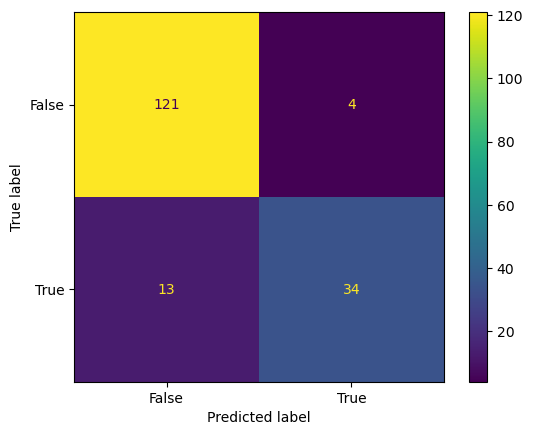

In [38]:
# Get the Confusion Matrix for the predicted and CalEnviroScreen4.0 classifications of EJ Communities
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

When we use all of the variables from CalEnviroScreen4.0 and the additional variables, only four out of 168 census tracts are classified as Environmental Justice communities by the RandomForest Classifier which are not classified as Environmental Justice communities under CalEnviroScreen4.0 for communities at or above the 75th percentile for their overall scores. The model also fails to classify 13 census tracts as Environmental Justice communities which are classified as disadvantaged by CalEnviroScreen4.0.  

Text(0, 0.5, 'Mean decrease in impurity')

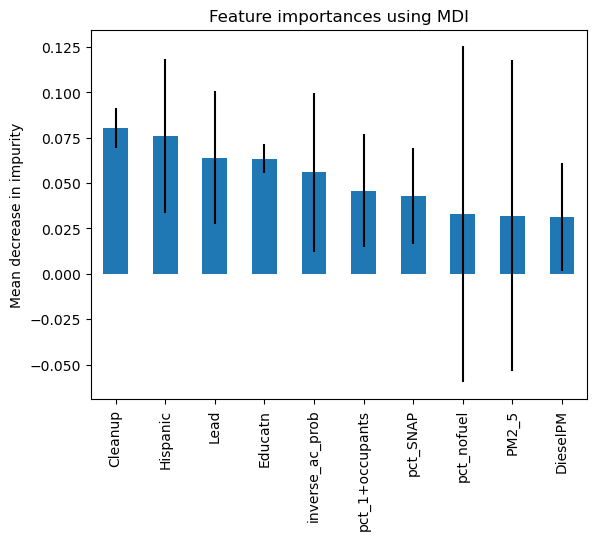

In [39]:
import matplotlib.pyplot as plt
# Determine which variables are most important for predicting EJ Communities
importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# Plot the top 10 variables and their importances
fig, ax = plt.subplots()
forest_importances[:10].plot.bar(yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

The top ten feature importances and their data sources include  Cleanup (CalEnviroScreen), Hispanic (CalEnviroScreen), Lead (CalEnviroScreen) Educatn (CalEnviroScreen), inverse_ac_prob (Romitti et al. 2022), pct_1+occupants (ACS), pct_SNAP (USDA), pct_nofuel (ACS), PM2_5 (CalEnviroScreen), and DieselPM (CalEnviroScreen). Each of the ten variables are significantly influential to the prediction. Note that pct_nofuel and PM2_5 have long error bars, suggesting a larger spread of values. 

Cleanup is a measure of the sum of weighted sites (based on the nature and the magnitude of the threat and burden posed
by hazardous substances, and site status) within each census tract. 
Hispanic is a measure of the number of census respondents who identified as Hispanic or Latino. 
Lead is a measure of the potential risk for lead exposure in children living in low-income communities with older housing. 
Educatn is a measure of the share of the population over the age of 25 with less than a high school education. 
Inverse_ac_prob is a measure of the inverse of numeric probability at the census tract level of any residential AC, meaning the numeric probability at the census tract level without any residential AC. The inverse_ac_prob variable is calculated using covariates that represent housing characteristics (unit type, tenure, number of bedrooms, and real market value) and household characteristics (income, educational attainment, age, race, and ethnicity). Inverse_ac_prob may roughly measure the same underlying construct as Hispanic, Educatn, and pct_1+occupants.
pct_1+occupants is the percentage of households with more than 1 occupant per room. 
pct_SNAP is the percentage of households receiving SNAP benefits. 
pct_nofuel is the percentage of households without heating fuel. 
PM2_5 is the annual mean concentration of PM2.5 (weighted average of measured monitor concentrations and satellite observations, µg/m3), over three years (2015 to 2017). 
DieselPM is a measure of the spatial distribution of gridded diesel PM emissions from on-road and non-road sources 2016 (tons/year).

It makes sense that a signficant share of the most predictive variables are CalEnviroScreen indicators given that the model is predicting whether the census tract is a CalEnviroScreen designated environmental justice community. The importance of these features largely aligns with our prior expectations, reinforcing the relationship between environmental justice communities and hazardous sites, racial demographics, lead exposure, educational attainment, housing affordability, food access, and air quality. The rank ordering is somewhat surprising. In particular, the significance of child lead exposure risk, air conditioning access, and lack of housing fuel. In addition, we assumed that air quality indicators would have a higher feature importance. 

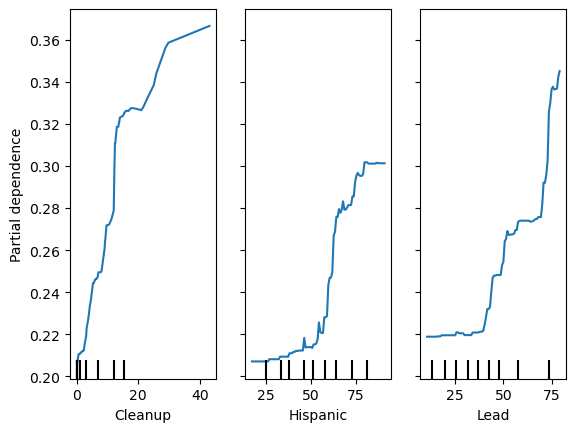

In [40]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf, X_test,
                                       forest_importances.index[:3])

Looking at the partial dependence of the variabels with the highest MDI can help us better understand how each feature influences the model and the relationship between that feature and the target variable. 

The partial dependence graphs of Cleanup, Hispanic, and Lead each have a predominantly positive slope, suggesting that an increase the in the variable leads to an increase in the predicted outcome (EJ community). 

It is important to remember that the feature importances do not imply causality alone. However, in connection with our domain knowledge, it can help to reinforce our understanding of EJ communities. Additionally, the most influential variables largely aligning with our expectations also reinforces our trust in the model. It is worthwhile questioning the usefulness of the model. Our research interest is in expanding definitions of EJ communities to ensure that vulnerable populations are not excluded from programming or funding opportunities. This model is most useful for understanding CalEnviroScreen EJ communities, what indicators EJ policy should be targeted for, and may help local jurisdictions identify what variables they should be using when identifying their own disadvantaged communities. 

## Assessing the Model and Interpreting Predictions

In [169]:
import contextily as ctx
import matplotlib.pyplot as plt

In [84]:
# Create geodataframe of prediction probabilities
joinedDfs = dfs[0].join(dfs[1:])
geometryDfs = joinedDfs['geometry']

# Concatenate X_test and X_train so all data is mapped
predictions = pd.DataFrame(rf.predict_proba(pd.concat([X_test,X_train])), 
                           columns = ['pred_noEJ', 'pred_EJ'])
predictions = predictions.join(pd.concat([X_test,X_train]).reset_index())
predictions.set_index('GEOID', inplace=True)
predictions = predictions.join(geometryDfs)
predictions = gpd.GeoDataFrame(predictions, geometry = predictions['geometry'], crs='EPSG:4326')

,pred_noEJ,pred_EJ,Ozone,PM2_5,DieselPM,Pesticide,Tox_Rel,Traffic,DrinkWat,Lead,...,pct_activecommute,pct_extremecommute,pct_nofuel,pct_1+occupants,HAMFI30,proj_avg_tmax,perc_no_tree_canopy,inverse_ac_prob,pct_SNAP,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
06065045707,0.45,0.55,0.062365,7.424580,0.100605,228.100781,0.579080,507.950058,274.751550,34.695733,...,1.364966,2.959761,4.492024,7.052897,28.310502,116.64,97.70,1.030141,18.075601,"POLYGON ((355027.330 -474699.170, 354527.523 -..."
06071004301,0.22,0.78,0.070001,11.660655,0.196282,0.000000,1073.660339,718.630050,731.925863,78.341914,...,1.625590,3.118280,0.285171,18.060837,5.857143,113.21,95.86,1.061977,35.169881,"POLYGON ((244553.604 -429714.830, 244557.622 -..."
06071000504,0.88,0.12,0.056130,12.894986,0.194518,0.023796,1010.325338,617.550138,937.762708,27.957977,...,0.502513,3.339270,3.303965,4.992658,7.197943,103.97,96.49,1.029904,3.016086,"POLYGON ((215438.332 -442190.782, 215500.369 -..."
06071001901,0.99,0.01,0.057631,13.196286,0.133150,16.242535,1033.121033,357.947913,937.762708,14.720526,...,0.000000,7.957682,0.716846,1.792115,34.482759,103.97,96.57,1.020947,3.489097,"POLYGON ((216303.193 -443769.566, 215500.369 -..."
06065043312,0.83,0.17,0.063506,9.022754,0.048348,0.000000,153.739936,680.003861,572.578266,52.561489,...,0.812458,12.586926,1.021277,13.531915,7.874016,109.83,98.40,1.052351,20.686695,"POLYGON ((282316.625 -472035.255, 281109.941 -..."


### Comparing CalEnviroScreen 4.0 Predictions with ML Model Prediction Probability

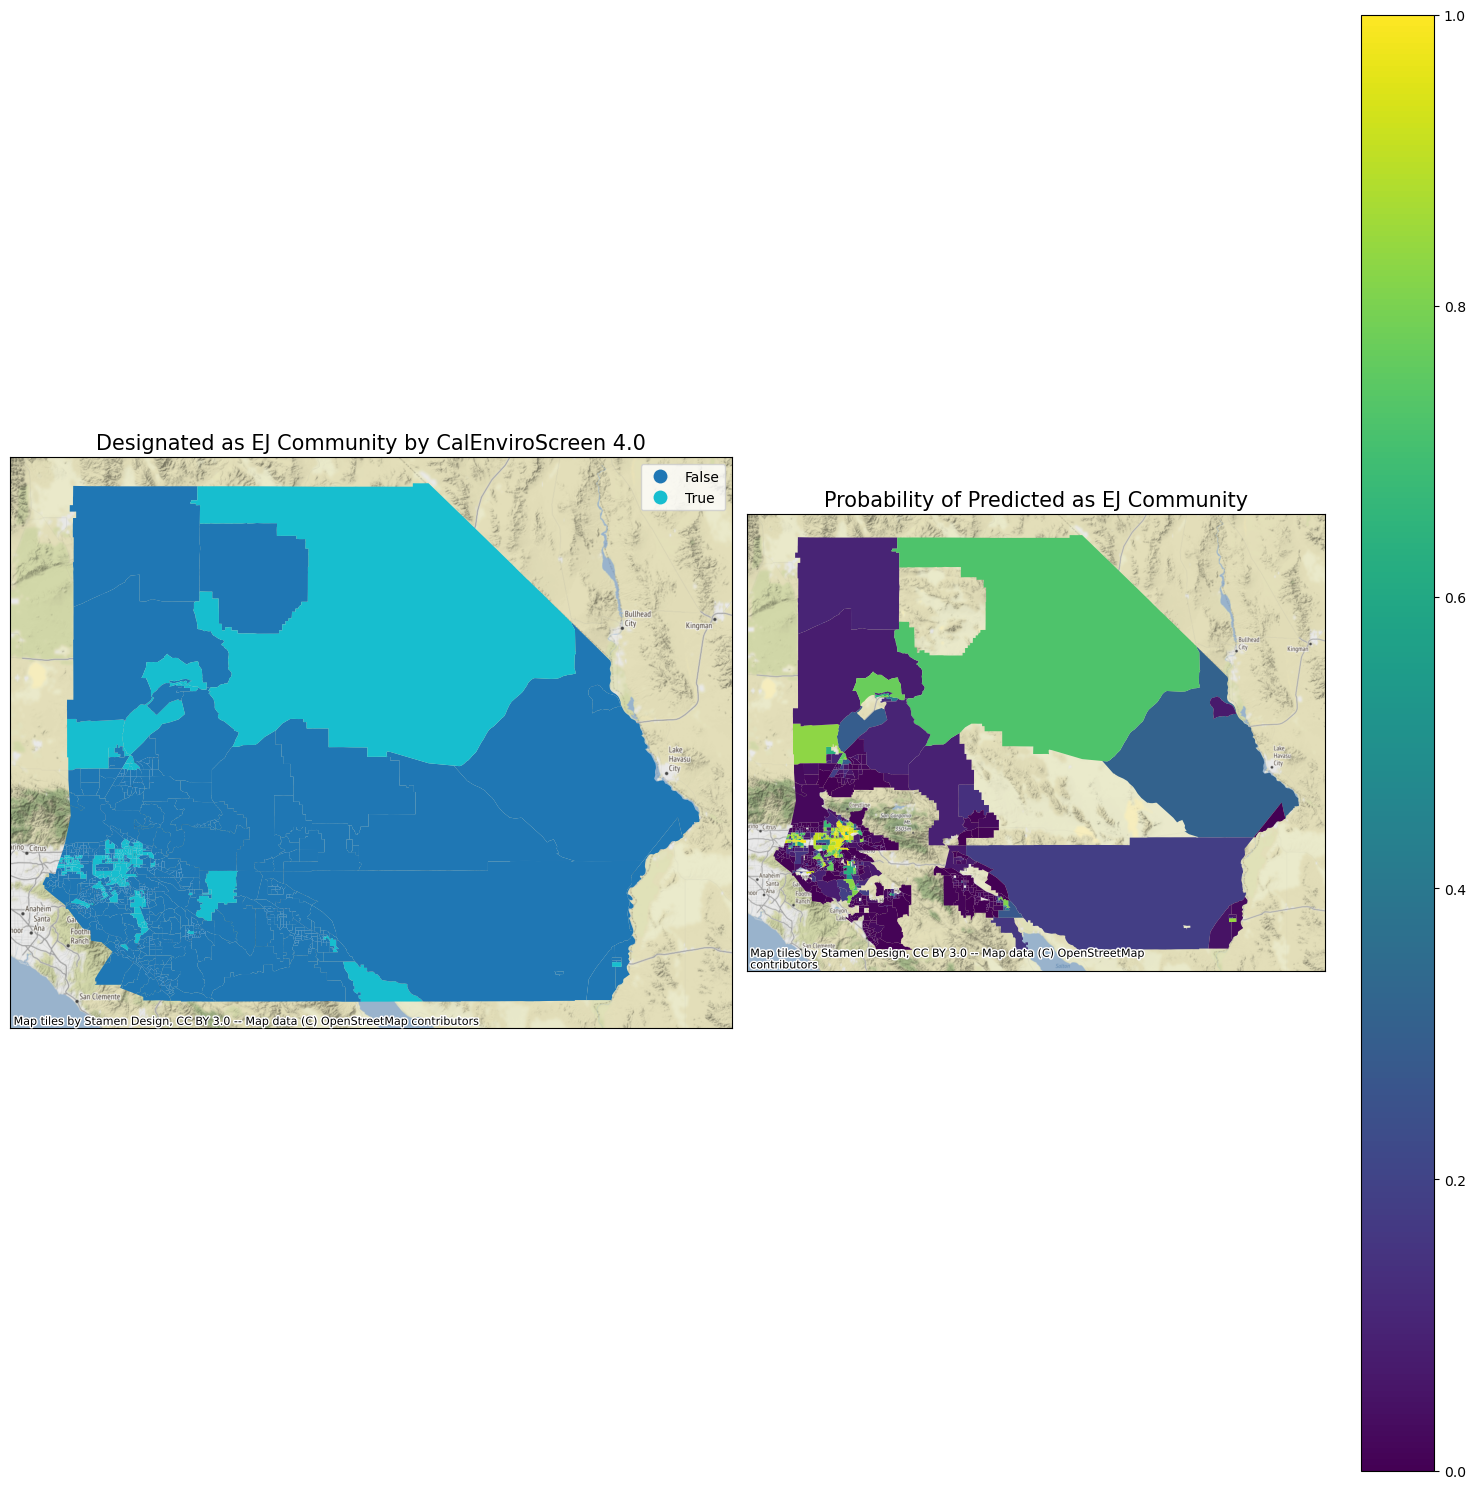

In [182]:
# Create side-by-side map of CalEnviroScreen predictions with ML model prediction probability 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
esGdf_InlandEmpire.to_crs('EPSG:3857').plot('CalEnviroScreen_EJ', ax=ax1, legend=True)
predictions.to_crs('EPSG:3857').plot('pred_EJ', ax=ax2, legend=True)

# Add basemaps
ctx.add_basemap(ax=ax1)
ctx.add_basemap(ax=ax2)

# Set titles and formatting
ax1.set_title('Designated as EJ Community by CalEnviroScreen 4.0', fontsize=15)
ax2.set_title('Probability of Predicted as EJ Community by ML Model', fontsize=15)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
fig.tight_layout()
plt.show()

The map on the left displays the disadvantaged community designations for each census tract under CalEnviroScreen 4.0. The map on the right highlights the census tracts with a high probability of being classified as an EJ community. Because the NaNs have been dropped for the ML, there are a number of census tracts missing. The probability may be a useful threshold for local jurisdictions identifying their own EJ communities. For instance, census tracts with a high probability of being predicted as an EJ community may still be worthwhile to identify as an EJ community to ensure that a more equitable share of more vulnerable and/or more impacted communities are prioritized. 

Seeing these maps side-by-side emphasizes the predictive power of the ML model. 

### Interpreting False Predictions

In [188]:
# Identify false positives and false negatives
false_positives = X_test[(y_pred == 1) & (y_test == 0)]
false_positives['false'] = 'False Positive'
false_negatives = X_test[(y_pred == 0) & (y_test == 1)]
false_negatives['false'] = 'False Negative'

# Create geodataframe with false predictions
falsepred = pd.DataFrame(pd.concat([false_positives,false_negatives]))
falsepred = falsepred.join(geometryDfs)
falsepred = gpd.GeoDataFrame(falsepred, geometry = falsepred['geometry'], crs='EPSG:4326')

/var/folders/nt/pqtkb2xn7dv92qdv8m3dc9380000gn/T/ipykernel_49343/1531826691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives['false'] = 'False Positive'
/var/folders/nt/pqtkb2xn7dv92qdv8m3dc9380000gn/T/ipykernel_49343/1531826691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives['false'] = 'False Negative'


Text(0.5, 1.0, 'Inaccurate ML Predictions')

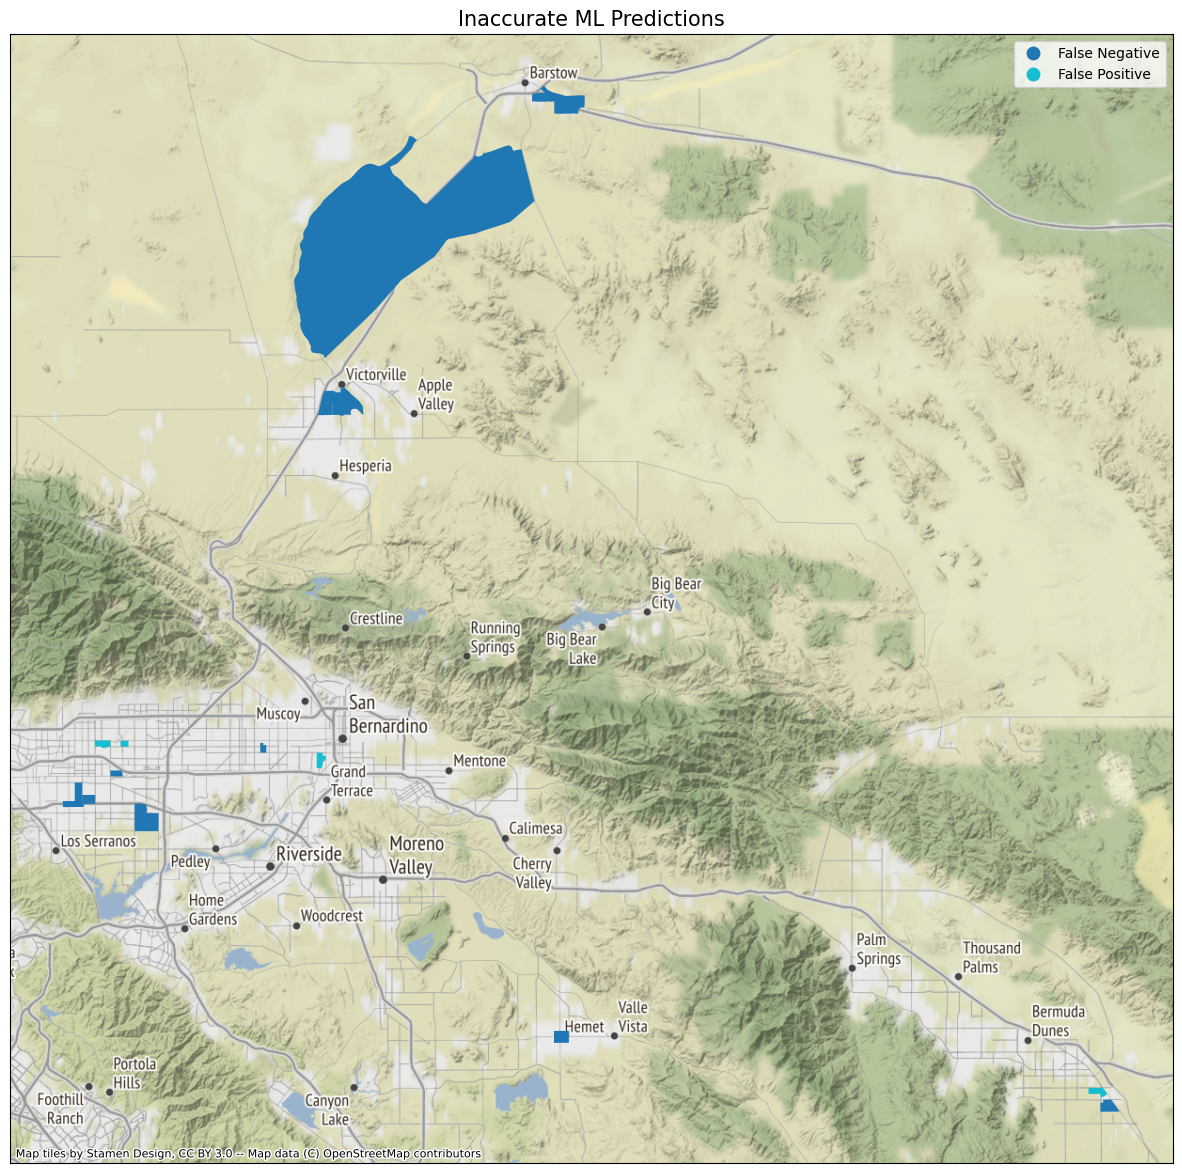

In [189]:
# Map false predictions
fig, ax = plt.subplots(figsize=(15,15))
falsepred.to_crs('EPSG:3857').plot('false', ax=ax, legend=True)
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Inaccurate ML Predictions', fontsize=15)

The map above displays the census tracts inaccurately predicted by the ML model. There are a greater share of false negatives (dark blue) than false positives (light blue). If this model were to be used for planning purposes, this tendency would be disadvantageous from an equity standpoint as it would be better to use a more inclusive definition for EJ communities to ensure vulnerable populations are not left behind. 

### False Predictions and Community Characteristics

#### False Positives

In [218]:
# Identify true positives
true_positives = X_test[(y_pred == 1) & (y_test == 1)]
# Edit tract number to match the GEOID in other datasets; add leading zero
esGdf['GEOID'] = esGdf.Tract.astype(np.int64).astype(str).str.zfill(11)
esGdf.set_index('GEOID', inplace=True)
true_positives = true_positives.join(esGdf['CIscoreP'])

In [219]:
# Add CIscoreP to false_positives
false_positives = false_positives.join(esGdf['CIscoreP'])
print('Top 10 Feature Importances Summary Statistics for False Positives')
print(false_positives[forest_importances.index[:10]].describe())
print('Top 10 Feature Importances Summary Statistics for True Positives')
print(true_positives[forest_importances.index[:10]].describe())
print('CalEnviroScreen Score Percentile Summary Statistics for False Positives')
print(false_positives['CIscoreP'].describe())
print('CalEnviroScreen Score Percentile Summary Statistics for True Positives')
print(true_positives['CIscoreP'].describe())

Top 10 Feature Importances Summary Statistics for False Positives
         Cleanup   Hispanic       Lead   Educatn  inverse_ac_prob  \
count   4.000000   4.000000   4.000000   4.00000         4.000000   
mean   11.187500  71.856850  54.128843  24.02500         1.049097   
std     3.715816  24.571621  21.562173  11.48343         0.016862   
min     6.750000  44.956900  34.695733  13.80000         1.030141   
25%     9.187500  54.938500  37.155704  16.12500         1.039253   
50%    11.250000  71.959100  51.027402  21.45000         1.048337   
75%    13.250000  88.877450  68.000541  29.35000         1.058182   
max    15.500000  98.552300  79.764835  39.40000         1.069575   

       pct_1+occupants   pct_SNAP  pct_nofuel      PM2_5  DieselPM  
count         4.000000   4.000000    4.000000   4.000000  4.000000  
mean          8.679725  19.138365    2.484763  12.270463  0.207762  
std           2.294518   3.431000    1.599326   3.581643  0.100612  
min           6.418338  15.518274   

##### Comparing Top 10 Feature Importances Between False Positives and True Positives

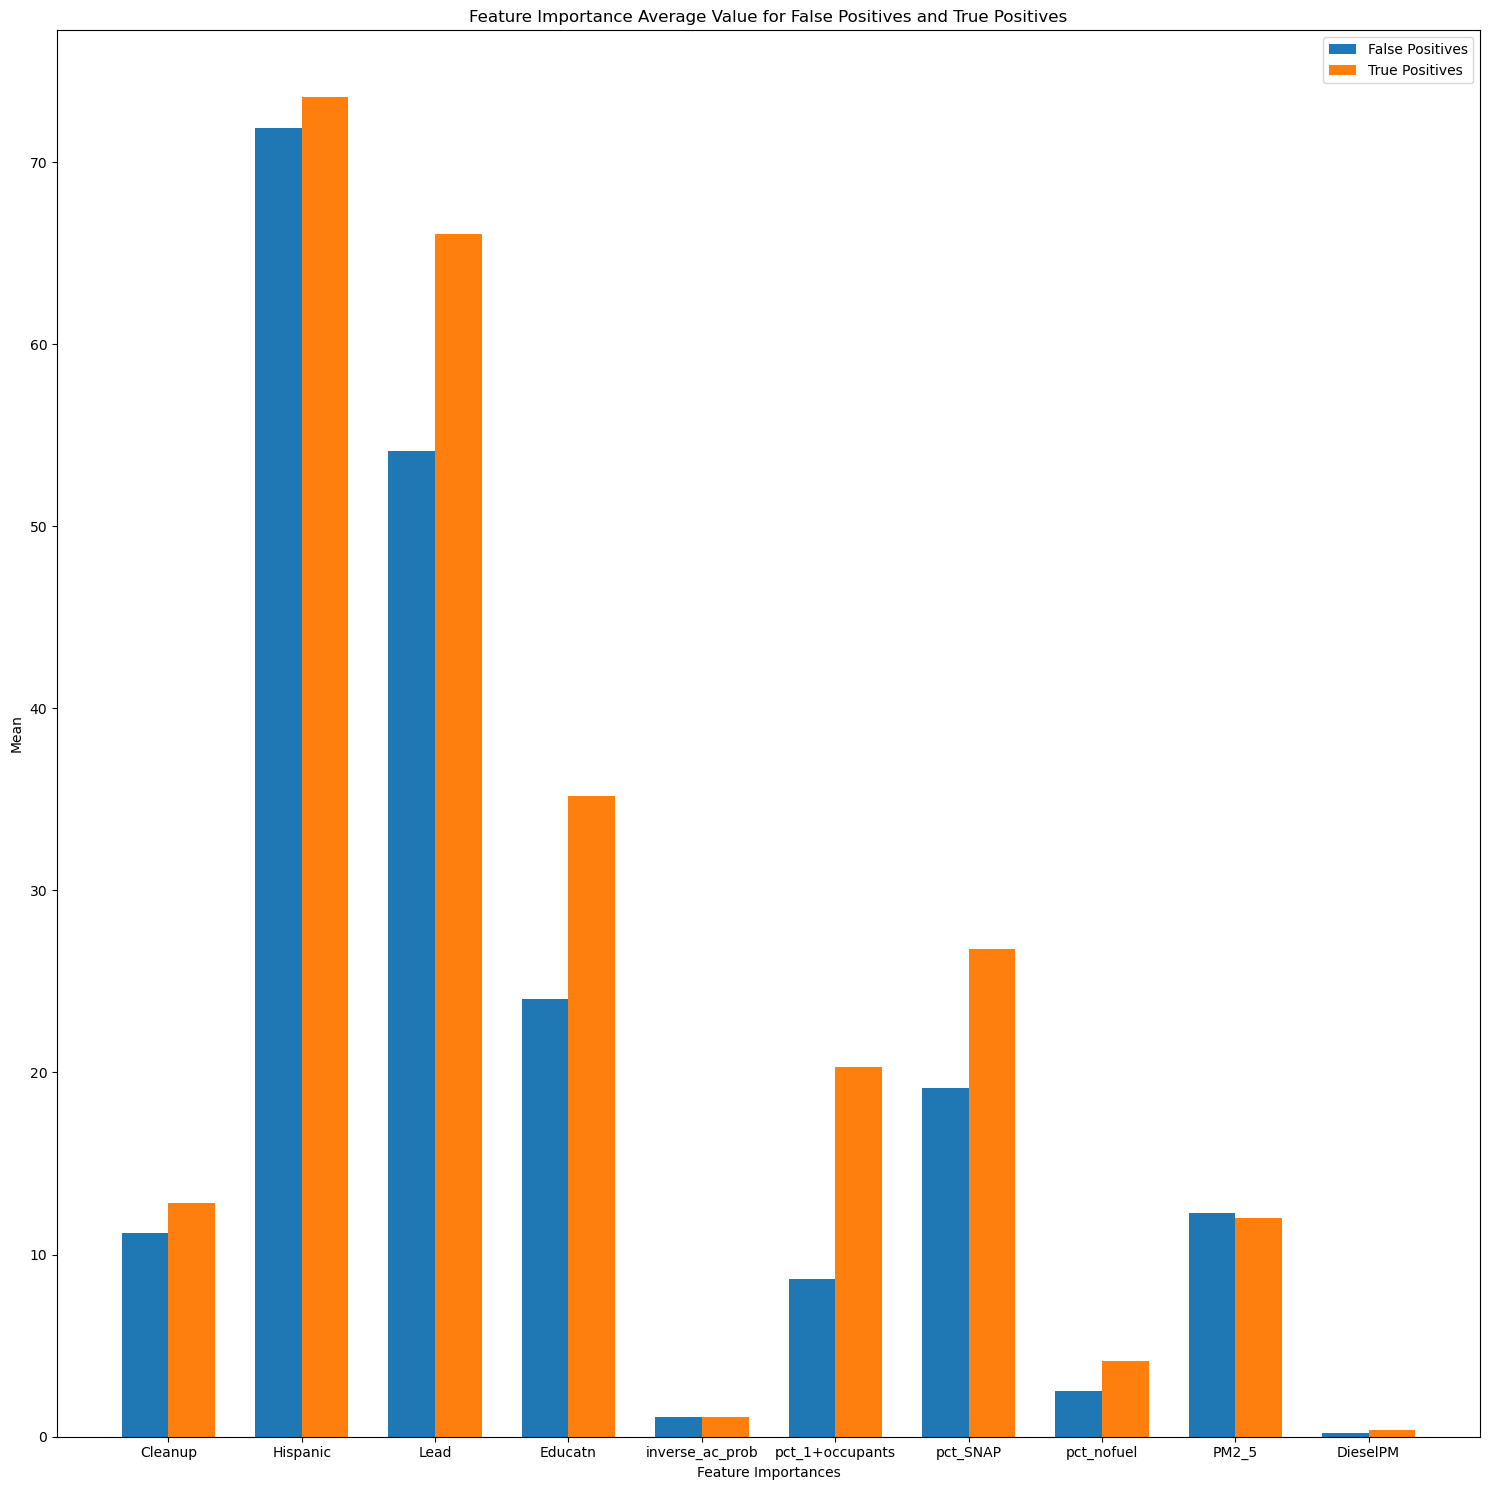

In [235]:
# Calculate mean value for each feature importance
false_pos_mean = false_positives[forest_importances.index[:10]].mean()
true_pos_mean = true_positives[forest_importances.index[:10]].mean()

# Create barplot
width = 0.35
x = np.arange(10)
fig, ax = plt.subplots(figsize=(15,15))
ax.bar(x - width/2, false_pos_mean, width, label='False Positives')
ax.bar(x + width/2, true_pos_mean, width, label='True Positives')

ax.set_xticks(x)
ax.set_xticklabels(forest_importances.index[:10])
ax.set_xlabel('Feature Importances')
ax.set_ylabel('Mean')
ax.set_title('Feature Importance Average Value for False Positives and True Positives')

ax.legend()
fig.tight_layout()
plt.show()

Census tracts predicted as true positives have a slightly higher value for each of the top ten feature importances than census tracts predicted as false positives. 

In [ ]:
##### Comparing CalEnviroScreen Score Percentiles Between False Positives and True Positives

In [263]:
falseposCIscore = false_positives['CIscoreP'].mean()
trueposCIscore = true_positives['CIscoreP'].mean()
print('The average CalEnviroScreen Score Percentile for census tracts that were predicted by the model as a false positive are:')
print(falseposCIscore)
print('The average CalEnviroScreen Score Percentile for census tracts that were predicted by the model as a true positive are:')
print(trueposCIscore)


The average CalEnviroScreen Score Percentile for census tracts that were predicted by the model as a false positive are:
71.438477055
The average CalEnviroScreen Score Percentile for census tracts that were predicted by the model as a true positive are:
87.92196909058825


The model identified tracts as false positives that were slightly below the CalEnviroScreen disadvantaged communities threshold (on average, around 4%). 

#### False Negatives

In [267]:
# Identify true negatives
true_negatives = X_test[(y_pred == 0) & (y_test == 0)]
# Edit tract number to match the GEOID in other datasets; add leading zero
esGdf['GEOID'] = esGdf.Tract.astype(np.int64).astype(str).str.zfill(11)
esGdf.set_index('GEOID', inplace=True)
true_negatives = true_negatives.join(esGdf['CIscoreP'])

In [249]:
# Add CIscoreP to false_negatives
false_negatives = false_negatives.join(esGdf['CIscoreP'])

##### Comparing Top 10 Feature Importances Between False Positives and True Positives

In [268]:
print('Top 10 Feature Importances Summary Statistics for False Negatives')
print(false_negatives[forest_importances.index[:10]].describe())
print('Top 10 Feature Importances Summary Statistics for True Negatives')
print(true_negatives[forest_importances.index[:10]].describe())

Top 10 Feature Importances Summary Statistics for False Negatives
         Cleanup   Hispanic       Lead    Educatn  inverse_ac_prob  \
count  13.000000  13.000000  13.000000  13.000000        13.000000   
mean    4.726923  63.237277  45.848102  23.938462         1.043670   
std     6.583395  14.141074  16.938085   7.774589         0.012930   
min     0.000000  46.280300  15.384380  12.100000         1.022768   
25%     0.000000  53.900600  38.280489  19.200000         1.036692   
50%     0.800000  59.000000  44.599508  25.900000         1.041853   
75%     9.000000  71.561800  57.476773  29.100000         1.054968   
max    17.600000  98.152200  80.526329  37.900000         1.066257   

       pct_1+occupants   pct_SNAP  pct_nofuel      PM2_5   DieselPM  
count        13.000000  13.000000   13.000000  13.000000  13.000000  
mean         10.929145  19.013584    1.995400  10.769015   0.233659  
std           6.453479  10.011518    1.486939   2.987567   0.166358  
min           2.703881 

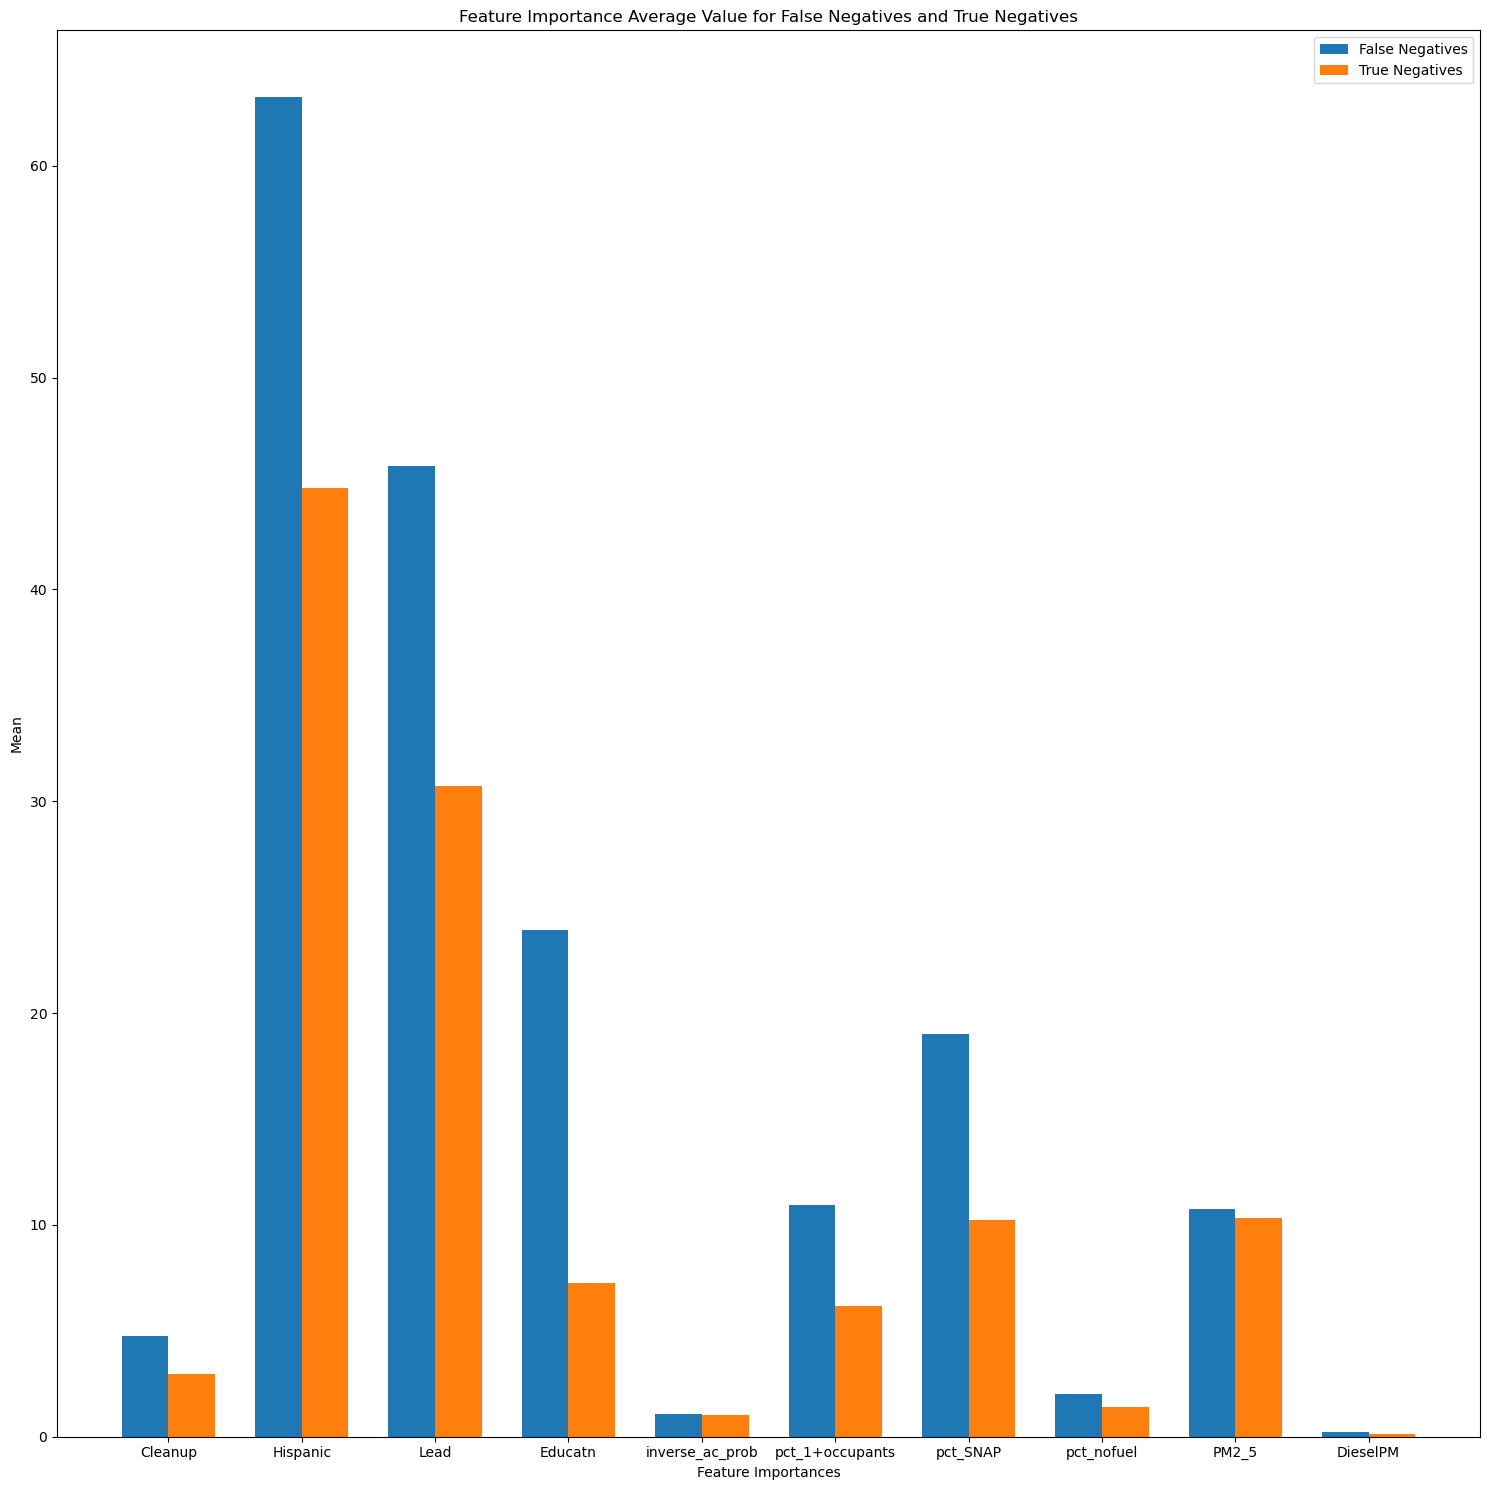

In [269]:
# Calculate mean value for each feature importance
false_neg_mean = false_negatives[forest_importances.index[:10]].mean()
true_neg_mean = true_negatives[forest_importances.index[:10]].mean()

# Create barplot
width = 0.35
x = np.arange(10)
fig, ax = plt.subplots(figsize=(15,15))
ax.bar(x - width/2, false_neg_mean, width, label='False Negatives')
ax.bar(x + width/2, true_neg_mean, width, label='True Negatives')

ax.set_xticks(x)
ax.set_xticklabels(forest_importances.index[:10])
ax.set_xlabel('Feature Importances')
ax.set_ylabel('Mean')
ax.set_title('Feature Importance Average Value for False Negatives and True Negatives')

ax.legend()
fig.tight_layout()
plt.show()

The census tracts predicted as false negatives had higher average values for the top ten feature importances than the census tracts predicted as true negatives. This is surprising as these indicators are positively associated with the target outcome. 

##### Comparing CalEnviroScreen Score Percentiles Between False Positives and True Positives

In [264]:
falsenegCIscore = false_negatives['CIscoreP'].mean()
truenegCIscore = true_negatives['CIscoreP'].mean()
print('The average CalEnviroScreen Score Percentile for census tracts that were predicted by the model as a false negative are:')
print(falsenegCIscore)
print('The average CalEnviroScreen Score Percentile for census tracts that were predicted by the model as a true negative are:')
print(truenegCIscore)

The average CalEnviroScreen Score Percentile for census tracts that were predicted by the model as a false negative are:
79.46196516692308
The average CalEnviroScreen Score Percentile for census tracts that were predicted by the model as a true negative are:
43.74768174120661


The model identified tracts as false negatives that were slightly above the CalEnviroScreen disadvantaged communities threshold (on average, around 5%). 

# Cluster Analysis to break down EJ Communities by characteristics 

Do the predicted EJ communities in the Inland Empire have similar characteristics? How do the communities predicted as EJ by ML but not CalEnviroScreen4.0 or vice versa fit into these clusters?

In [ ]:
# Get prediction about EJ community status for all census tracts: including testing and training datasets
# create a dataframe of the probabilities
predictions = pd.DataFrame(rf.predict_proba(pd.concat([X_test,X_train])), 
                           columns = ['pred_notEJ', 'pred_EJ'])

In [ ]:
# We can join the predictions with the x-variables
predictions= predictions.join(pd.concat([X_test,X_train]).reset_index())

In [ ]:
# Join the geometry from the CalEnviroScreen shapefile with the predictions df 
esGdf_InlandEmpire_geo= esGdf_InlandEmpire[['geometry', 'CalEnviroScreen_EJ']]
#esGdf_InlandEmpire_geo.name = 'census_geometry'

In [ ]:
# Merge the predictions with the CalEnviroScreen geometry and EJ designation
predictions_geo = esGdf_InlandEmpire_geo.merge(predictions, left_index=True, right_on='GEOID')
# Set GEOID as index 
predictions_geo.set_index('GEOID', inplace=True)

In [ ]:
# Prepare data for Cluster Analysis
# see https://scikit-learn.org/stable/modules/preprocessing.html for standardization
from sklearn import preprocessing
# Use all columns except geometry column, CalEnviroScreen result, and pred_notEJ (just 1-pred_EJ)
cols_to_exclude= ['geometry', 'CalEnviroScreen_EJ', 'pred_notEJ']
cols_to_plot = [col for col in predictions_geo.columns if col not in (cols_to_exclude)]
scaler = preprocessing.StandardScaler().fit(predictions_geo[cols_to_plot])

# the scaler returns a numpy array, so we cast this as a DataFrame 
# and need to specify the column names and index
df_scaled = pd.DataFrame(scaler.transform(predictions_geo[cols_to_plot]), 
                         columns=cols_to_plot, index=predictions_geo.index)

In [ ]:
# Perform k means analysis
from sklearn.cluster import KMeans
# Drop the NaN values 
df_scaled= df_scaled.dropna()
# Run KMeans algorithm
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_scaled)
# Add cluster id back to scaled dataframe
df_scaled['cluster_id'] = kmeans.labels_

In [ ]:
# Size of each cluster
csizes = df_scaled.groupby('cluster_id').size()
# then insert that into the string
# you'd change this in the function above, not here
k = kmeans.n_clusters
labels = ['Cluster {} (N={})'.format(kk, csizes.loc[kk]) for kk in range(k)]
labels

Use the radar plot function to visualize how our clusters relate to the CalEnviroScreen4.0 variables

In [ ]:
# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

In [ ]:
# Drop the cluster_id column
df_scaled= df_scaled.drop(columns='cluster_id')

In [ ]:
# Call the radar plot function with transit agency data
radar_plot(kmeans, df_scaled)

In [ ]:
# Add cluster id back to scaled dataframe
df_scaled['cluster_id'] = kmeans.labels_

# Merge the standardized cluster data with the CalEnviroScreen geometry and EJ designation
cluster_geo = esGdf_InlandEmpire_geo.merge(df_scaled, left_index=True, right_index=True)

# Get the census tracts that are classified as EJ by ML but not CalEnviroScreen4.0
ML_EJ = cluster_geo[(cluster_geo.index.isin(pred_v_CalEnviro_diff.GEOID)==True) & (cluster_geo.CalEnviroScreen_EJ == False)]

# Get the census tracts that are classified as EJ by CalEnviroScreen4.0 but not ML 
CalEnviro_EJ = cluster_geo[(cluster_geo.index.isin(pred_v_CalEnviro_diff.GEOID)==True) & (cluster_geo.CalEnviroScreen_EJ == True)]

# Which clusters represent these census tracts? 
CalEnviro_EJ.groupby(['cluster_id']).size()

# Map the clusters
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#7fc97f'), (0.2, '#beaed4'), (0.4, '#fdc086'), 
               (0.6, '#ffff99'), (0.8, '#386cb0'), (1.0, '0.5')])

fig, ax = plt.subplots(figsize=(10,10))
# Identify each census tract by its cluster 
cluster_geo.to_crs('EPSG:3857').plot('cluster_id', ax=ax, categorical=True, legend=True,
                                 alpha=0.5, cmap=cmap, legend_kwds={'loc': 'upper left'})

# Get the centroids of the census tracts where ML and CalEnviroScreen4.0 disagree
ML_EJ.geometry = ML_EJ.geometry.centroid
CalEnviro_EJ.geometry= CalEnviro_EJ.geometry.centroid

# Mark the locations of census tracts identified as EJ by ML but not CalEnviroScreen4.0 
ML_EJ.to_crs('EPSG:3857').plot('CalEnviroScreen_EJ', categorical=True, markersize=10, ax=ax, color='purple', legend=True)
# Mark the location of census tracts identified as EJ by CalEnviroScreen4.0
CalEnviro_EJ.to_crs('EPSG:3857').plot('CalEnviroScreen_EJ', categorical=True, markersize=10, ax=ax, color='red', legend=True)

# add a legend title
legend = ax.get_legend()
legend.set_title("Cluster", prop={'size':10} )

# Add basemap and title but exclude 
ctx.add_basemap(ax=ax, alpha=0.8)
ax.set_title('Census Tracts Clustered on Environmental Justice Characteristics', fontsize=10)  
plt.annotate('Red points are census tracts identified as EJ by CalEnviroScreen4.0 but not ML', (-1.3015e7, 4.25e6), color='red', fontsize= 10)
plt.annotate('Purple points are census tracts identified as EJ by ML but not CalEnviroScreen4.0', (-1.3015e7, 4.23e6), color='purple', fontsize= 10)
#ax.set_xticks([])
#ax.set_yticks([])
plt.show()



We have a lot of variables to cluster the census tracts on. The two clusters which are above the standard deviation for predicted_EJ, which quantifies the probability that a given census tract is an Environmental Justice community, are Clusters 2 and 3. Cluster 2 is characterized by census tracts with high SNAP usage, low probability of residential air conditioning, greater overcrowding, less households with heating fuel, low Internet access and subscriptions, high Hispanic populations, poverty, asthma, percent children under 5, and lead in homes. This group is mainly characterized to low socioeconomic status, which is related to race/ethnicity and some environmental exposures as well. The map shows that cluster 2 census tracts are often located in more rural locations, like in the Mojave Desert, farther from the more urban and suburban areas surrounding Riverside and San Bernardino cities. 

Cluster 3 has similar characteristics to Cluster 2 in that it has high proportions of Hispanic residents, high overcrowding, less households with heating fuels, and high lead exposure. However, Cluster 3 also exceeds other clusters in exposures to PM2.5, diesel particulates, toxic release, traffic, polluted drinking water, and hazardous waste. This cluster is mainly characterized by high pollution exposures and which are also related to some factors for low socioeconomic status and race/ethnicity. Cluster 3 census tracts are more urban/suburban, concentrated around the cities of San Bernardino and Riverside. 

All of the census tracts classified as EJ by ML but not CalEnviroScreen4.0 were in cluster 3. For the census tracts classified as EJ by CalEnviroScreen4.0 but not the ML model, 2 were in cluster 0, 4 were in cluster 2, 6 were in cluster 3, and 2 were in cluster 4. Thus, our model doesn't necessarily exclude census tracts from a particular cluster. This supports our analysis above. However, it does not greatly expand any of our clusters either. 